# Brain Tumor MR Image Classification

In this model we have used VGG16 Network as CNN for constructing Brain Image Classifier.

In [0]:
# Import resources
import os
import numpy as np
import pandas as pd
import cv2
import imutils
import shutil
import torch
from PIL import Image
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets, models, transforms
import torchvision.models as models
import torch.utils.model_zoo
import seaborn as sns
import pickle
import matplotlib.pyplot as plt

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
# shutil.rmtree('./train')
# shutil.rmtree('./valid')

Import the data from MRI_data.zip

Here the data is provided in two folders namely 'Train' and 'Valid' which specifies training and validation set of images. These two folders contain two subfolders namely 'Yes' and 'No' specifying whether the brain images have tumor or not.

In [0]:
!unzip -qq MRI_data.zip

Sample Brain MR Image with Tumor

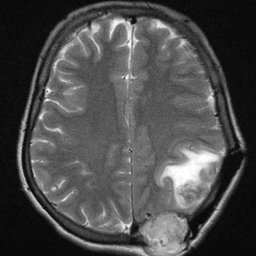

In [0]:
Image.open('./train/yes/Y102.jpg').resize((256,256))

Sample Brain MR Image without Tumor

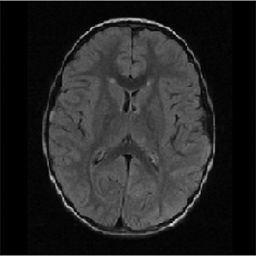

In [0]:
Image.open('./valid/no/no 89.jpg').resize((256,256))

Distribution of Classes in Brain Images

Text(0.5, 1.0, 'Distribution of Classes in Brain Images')

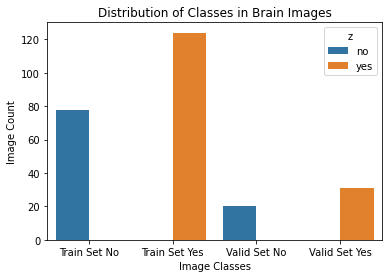

In [0]:
def fcount(path):
    #Counts the number of files in a directory
    count = 0
    for f in os.listdir(path):
        if os.path.isfile(os.path.join(path, f)):
            count += 1
    return count

path_tr_no = r"./train/no"
path_tr_yes = r"./train/yes"
path_va_no = r"./valid/no"
path_va_yes = r"./valid/yes"

tr_no = fcount(path_tr_no)
tr_yes = fcount(path_tr_yes)
va_no = fcount(path_va_no)
va_yes= fcount(path_va_yes)

df = pd.DataFrame() 
cnt_data = {'x':['Train Set No','Train Set Yes' ,'Valid Set No','Valid Set Yes'], 
            'y':[tr_no,tr_yes,va_no,va_yes],
            'z':['no','yes','no','yes']}
df = pd.DataFrame(cnt_data) 

ax=sns.barplot(x='x',y='y',hue='z',data=df)
ax.set(xlabel="Image Classes", ylabel = "Image Count")
ax.set_title("Distribution of Classes in Brain Images")

# Image Preprocessing

Step 1: Cropping the Images along the contours and Gaussian Blurring

In [0]:
# Cropping MRI Brain Images 
def load_edge_crop(filename):

    images = list()
    for fname in os.listdir(filename):
        img = cv2.imread(filename + '/' + fname,0)
        img = cv2.GaussianBlur(img, (5, 5), 0)

        # threshold the image, then perform a series of erosions +
        # dilations to remove any small regions of noise
        thresh = cv2.threshold(img, 45, 255, cv2.THRESH_BINARY)[1]
        thresh = cv2.erode(thresh, None, iterations=2)
        thresh = cv2.dilate(thresh, None, iterations=2)

        # find contours in thresholded image, then grab the largest one
        cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        cnts = imutils.grab_contours(cnts)
        c = max(cnts, key=cv2.contourArea)

        # find the extreme points
        extLeft = tuple(c[c[:, :, 0].argmin()][0])
        extRight = tuple(c[c[:, :, 0].argmax()][0])
        extTop = tuple(c[c[:, :, 1].argmin()][0])
        extBot = tuple(c[c[:, :, 1].argmax()][0])

        new_img = img[extTop[1]:extBot[1], extLeft[0]:extRight[0]].copy()
        new_img = cv2.resize(new_img,dsize=(32,32))
        images.append(new_img)

    shutil.rmtree(filename)
    os.mkdir(filename)

    for index,img in enumerate(images):
        cv2.imwrite(filename + '/' + str(index) + '.jpg',img)

load_edge_crop('./train/no')
load_edge_crop('./train/yes')
load_edge_crop('./valid/no')
load_edge_crop('./valid/yes')

Step 2: Data transformation such as image rotation, flipping, normalization and conversion of images into tensors

In [0]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomRotation(15),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                              [0.229, 0.224, 0.225])
    ]),
    'valid': transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], 
                              [0.229, 0.224, 0.225])
    ])
}

Loading the images into dataloaders as trainloaders and testloaders for training

In [0]:
data = {x: datasets.ImageFolder(os.path.join("",x),
                                          data_transforms[x])
                  for x in ['train', 'valid']}

In [0]:
dataloaders = {
    'train': torch.utils.data.DataLoader(data['train'], batch_size=16, shuffle=True),
    'valid': torch.utils.data.DataLoader(data['valid'], batch_size=4, shuffle=True)
} 

Checking the train data loaded in dataloader

In [0]:
for data, targets in dataloaders['valid']:
    print(data)
    print(targets)
    break

tensor([[[[-2.1179, -2.0665, -2.1179,  ..., -2.1179, -2.0665, -2.1179],
          [-2.1008, -2.1179, -2.1008,  ..., -2.1179, -2.1179, -2.0665],
          [-2.0494, -2.1179, -2.1179,  ..., -2.0665, -2.1179, -2.1008],
          ...,
          [-2.0665, -2.0837, -2.1179,  ..., -2.1179, -2.0837, -2.0665],
          [-2.1179, -2.1179, -2.0323,  ..., -2.0837, -2.0837, -2.1179],
          [-2.0837, -2.1179, -2.1179,  ..., -2.1179, -2.1008, -2.0665]],

         [[-2.0357, -1.9832, -2.0357,  ..., -2.0357, -1.9832, -2.0357],
          [-2.0182, -2.0357, -2.0182,  ..., -2.0357, -2.0357, -1.9832],
          [-1.9657, -2.0357, -2.0357,  ..., -1.9832, -2.0357, -2.0182],
          ...,
          [-1.9832, -2.0007, -2.0357,  ..., -2.0357, -2.0007, -1.9832],
          [-2.0357, -2.0357, -1.9482,  ..., -2.0007, -2.0007, -2.0357],
          [-2.0007, -2.0357, -2.0357,  ..., -2.0357, -2.0182, -1.9832]],

         [[-1.8044, -1.7522, -1.8044,  ..., -1.8044, -1.7522, -1.8044],
          [-1.7870, -1.8044, -

# Defining the VGG16 Model

In [0]:
model = models.vgg16(pretrained=True)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/checkpoints/vgg16-397923af.pth


Setting the parameters

In [0]:
for param in model.parameters():
    param.requires_grad = False

Constructing the model with VGG

In [0]:
model.classifier[6] = nn.Sequential(
                      nn.Linear(4096, 256), 
                      nn.ReLU(), 
                      nn.Dropout(0.4),
                      nn.Linear(256, 2),                   
                      nn.LogSoftmax(dim=1))

Summary of Model

In [0]:
model.classifier

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Sequential(
    (0): Linear(in_features=4096, out_features=256, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.4, inplace=False)
    (3): Linear(in_features=256, out_features=2, bias=True)
    (4): LogSoftmax()
  )
)

Declaring the parameters for model training

In [0]:
total_params = sum(p.numel() for p in model.parameters())
print(f'{total_params:,} total parameters.')
total_trainable_params = sum(
    p.numel() for p in model.parameters() if p.requires_grad)
print(f'{total_trainable_params:,} training parameters.')

135,309,890 total parameters.
1,049,346 training parameters.


Specifying Loss and optimizer Functions

In [0]:
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters())

Training the model with brain train images

In [0]:
for epoch in range(50):
  for data, targets in dataloaders['train']:
    # Generate predictions
    out = model(data)
    # Calculate loss
    loss = criterion(out, targets)
    # Backpropagation
    loss.backward()
    # Update model parameters
    optimizer.step()

Testing the model on test data and calculating accuarcy 

In [0]:
val_loss=0
correct=0
for data, targets in dataloaders['valid']:
  # Generate predictions 
  out = model(data)
  # Calculate loss
  loss = criterion(out, targets)
  val_loss += loss
  val_loss = val_loss / len(dataloaders['train'])

  testloader=dataloaders['valid']
  pred = out.max(1, keepdim=True)[1] 
  correct += pred.eq(targets.view_as(pred)).sum().item()
  accuracy=100. * correct / len(testloader.dataset)
  #print("Accuracy:",accuracy)
print('Test set: Average loss: {:.4f}\nAccuracy: {}/{} ({:.0f}%)'.format(
        val_loss, correct, len(testloader.dataset),
        accuracy))

Test set: Average loss: 0.0680
Accuracy: 29/51 (57%)


Model Performance

In [0]:
# printing accuracy and loss for each value in train set
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
acc_train=[]
loss_train=[]
pred_train=[]
trainloader=dataloaders['train']
model.eval()
test_loss = 0
correct = 0
with torch.no_grad():
    for data, target in (trainloader):
        data, target = data.to(device), target.to(device)
        output = model(data)
        test_loss = criterion(output, target).item()
        pred = output.max(1, keepdim=True)[1] 
        pred_train.append(pred)
        correct += pred.eq(target.view_as(pred)).sum().item()
        accuracy=100. * correct / len(trainloader.dataset)
        acc_train.append(accuracy)
        loss_train.append(test_loss)
epoch_count=range(1,14)

# printing accuracy and loss for each value in validation set
acc_valid=[]
loss_valid=[]
pred_valid=[]
testloader=dataloaders['valid']
model.eval()
test_loss = 0
correct = 0
with torch.no_grad():
    for data, target in (testloader):
        data, target = data.to(device), target.to(device)
        output = model(data)

        test_loss = criterion(output, target).item()
        pred = output.max(1, keepdim=True)[1] 
        pred_valid.append(pred)
        correct += pred.eq(target.view_as(pred)).sum().item()
        accuracy=100. * correct / len(testloader.dataset)
        acc_valid.append(accuracy)
        loss_valid.append(test_loss)
epoch_count2=range(1,14)

Accuracy Comparison

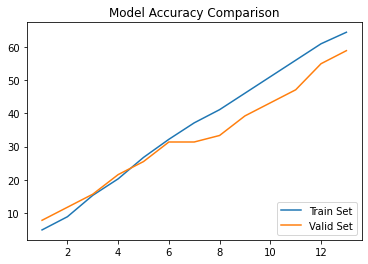

In [0]:
plt.plot(epoch_count, acc_train, label='Train Set')
plt.title("Model Accuracy Comparison")
plt.plot(epoch_count2, acc_valid, label='Valid Set')
plt.legend(loc='lower right')

Loss Comparison

Text(0.5, 1.0, 'Model Loss Comparison')

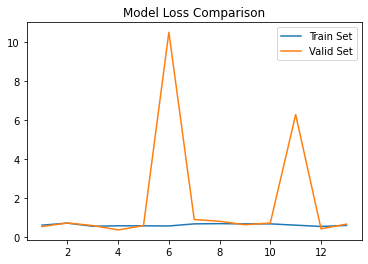

In [0]:
plt.plot(epoch_count, loss_train, label='Train Set')
plt.plot(epoch_count2, loss_valid, label='Valid Set')
plt.legend(loc='best')
plt.title("Model Loss Comparison")

Confusion Matrix

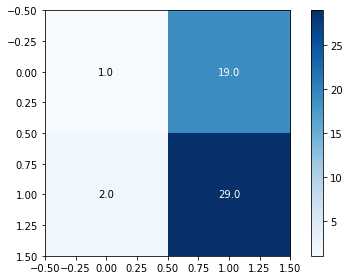

In [0]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
classes=['no', 'yes']
nb_classes = 2   
confusion_matrix = torch.zeros(nb_classes, nb_classes)

with torch.no_grad():
    for i, (inputs, target) in enumerate(dataloaders['valid']):

        inputs = inputs.to(device)
        target = target.to(device)

        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)

        for t, p in zip(target.view(-1), preds.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1

num_classes = 2
class_names = classes                

plt.figure()
plt.imshow(confusion_matrix, interpolation='nearest', cmap=plt.cm.Blues)

tick_marks = np.arange(num_classes)
classNames = class_names

thresh = confusion_matrix.max() / 2.
for i in range(confusion_matrix.shape[0]):
    for j in range(confusion_matrix.shape[1]):
        plt.text(j, i, format(confusion_matrix[i, j]),
                ha="center", va="center",
                color="white" if  confusion_matrix[i, j] == 0 or confusion_matrix[i, j] > thresh else "black") 
plt.tight_layout()
plt.colorbar()
plt.show()